<a href="https://colab.research.google.com/github/smsharma/iaifi-summer-school-tutorials/blob/main/02_deep_prob_prog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: An introduction to deep probabilistic programming

**IAIFI Summer School 2022 Tutorial for _Machine Learning for Beyond-the-Standard-Model Physics_**

**Siddharth Mishra-Sharma** ([smsharma@mit.edu](mailto:smsharma@mit.edu))


>[Tutorial 2: Deep probabilistic programming](#scrollTo=cRfs7iZQs3xU)

>>[1. Introduction](#scrollTo=94DhD6xJiSzi)

>>[2. Strong lensing simulator](#scrollTo=GSQ0LhmqnCZJ)

>>[3. Inferring the lens mass parameters](#scrollTo=qMGrQZ3ZnCZR)

>>[4. Gravitational lensing of MNIST sources](#scrollTo=h-6b_JHHBfZw)

>>[5. A generative model (VAE) for MNIST "sources"](#scrollTo=pSRFyrK2QVTA)

>>[6. Deep probabilistic programming model for lensing MNIST](#scrollTo=Y7tI7YjU_40p)



## 1.&nbsp;Introduction

- In this tutorial we will add to the toolbox we developed in the last notebook on differentiable probabilistic programming. 
- We will introduce _deep_ probabilistic programming, which combines some of the nice features of deep learning (e.g., the ability to model complex distributions of different data modalities, e.g. images) and probabilistic programming (everything we saw last time!). 

- **Physics example**: We will consider strong gravitational lensing---the bending of a background light by a foreground lens mass distribution. We will model the background source using a **generative model**---in particular, a **variational autoencoder**---which will then be included as an ingredient of the probabilistic model in order to reconstruct both the source light as well as the foreground lens mass distribution.

<img src="https://upload.wikimedia.org/wikipedia/commons/1/11/A_Horseshoe_Einstein_Ring_from_Hubble.JPG#" alt="Einstein ring" width="800"/>

In [1]:
! pip install flax numpyro corner tqdm
! pip install -q --upgrade jax[cuda11_cudnn805] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
! pip install pyyaml==5.4.1

In [2]:
import jax.numpy as jnp
import jax
from jax import random
import numpy as np

import matplotlib.pyplot as plt

## 2.&nbsp;Strong lensing simulator

<img src="https://raw.githubusercontent.com/smsharma/iaifi-summer-school-tutorials/main/assets/lens.png#" alt="Lens graphic" width="800"/>

- We'll start by implementing a differentiable simulator in `Jax` for lensing arbitrary background sources distributions. 
- The physical description of gravitational lensing is remarkably simply, with the "distortion" between the sources and lens planes described by the lens equation,
$$\vec\theta_\mathrm{source} = \vec\theta_\mathrm{lens} - \nabla_\theta \psi_\mathrm{G}(\vec\theta) $$
where $\nabla_\theta \psi_\mathrm{G}(\theta)$ is gradient of the projected potential of the lens and is known as the _deflection_.

- For many parameteric descriptions of the lens mass the deflection vector can be computed analytically, letting us "shift" source points into the lens plane. 
- For the Singular Isothermal Ellipsoid (SIE), a small generalization of the [Singular Isothermal Sphere](https://en.wikipedia.org/wiki/Singular_isothermal_sphere_profile), the deflection field is
\begin{aligned}
&\left[\nabla_\theta \psi_\mathrm{G}(\theta)\right]_x=\frac{\theta_{\mathrm{E}} q}{\sqrt{1-q^{2}}} \tan ^{-1}\left[\frac{\sqrt{1-q^{2}} \theta_{x}}{\chi}\right] \\
&\left[\nabla_\theta \psi_\mathrm{G}(\theta)\right]_y=\frac{\theta_{\mathrm{E}} q}{\sqrt{1-q^{2}}} \tanh ^{-1}\left[\frac{\sqrt{1-q^{2}} \theta_{y}}{\chi+q^{2}}\right]
\end{aligned}
where $\theta_\mathrm{E}$ (Einstein radius, specifying overall lensing scale) and $q$ (axis ratio) are parameters and $\chi \equiv \sqrt{\theta_{x}^{2} q^{2}+\theta_{y}^{2}}$.

Let's code up this deflection field.

In [3]:
class MassProfileSIE:
    def __init__(self, x_0, y_0, r_E, q):
        """
        Class to model lensing deflection field of SIE mass profile

        :param x_0: x-coordinate of center of deflector, in same units as r_E
        :param y_0: y-coordinate of center of deflector, in same units as r_E
        :param r_E: Einstein radius of deflector
        :param q: Axis-ratio of deflector
        """
        self.x_0 = x_0
        self.y_0 = y_0
        self.r_E = r_E
        self.q = q

    def deflection(self, x, y):
        """
        Calculate deflection vectors, from astro-ph/0102341

        :param x: x-coordinate at which deflection computed, in same units as r_E
        :param y: y-coordinate at which deflection computed, in same units as r_E
        :return: Deflections at positions specified by x, y
        """
        # Go into shifted coordinates
        x_p = x - self.x_0
        y_p = y - self.y_0
        
        # Compute deflection field
        xi = jnp.sqrt((self.q * x_p) ** 2 + y_p ** 2)

        x_d = jnp.where(self.q == 1., self.r_E * x_p / xi, self.r_E * self.q / jnp.sqrt(1 - self.q ** 2) * jnp.arctan(jnp.sqrt(1 - self.q ** 2) * x_p / xi))
        y_d = jnp.where(self.q == 1., self.r_E * y_p / xi, self.r_E * self.q / jnp.sqrt(1 - self.q ** 2) * jnp.arctanh(jnp.sqrt(1 - self.q ** 2) * y_p / xi))

        # Return deflection field
        return x_d, y_d


Next, let's code up the lensing simulator which takes in a source image as well as a few observational configurations (e.g., pixel size, exposure...) and generates and lensed image.

The lensed image can be obtained by evaluating the source image in the "shifted" coordinates:
$$
\text { Lensed image } \sim \text{Source image}\left(\vec{\theta}-\nabla_{\theta} \Psi_{\mathrm{G}}(\vec{\theta})\right)
$$

In [4]:
from jax.scipy.ndimage import map_coordinates


class LensingSim:
    def __init__(self, lenses_list=[{}], sources_list=[{}], observation_dict={}):
        """ Class for simulation of strong lensing images
        """

        self.lenses_list = lenses_list
        self.sources_list = sources_list

        self.observation_dict = observation_dict

        self.set_up_observation()


    def set_up_observation(self):
        """ Set up observational grid and parameters
        """
        
        # Coordinate limits (in arcsecs)
        self.theta_x_lims = self.observation_dict["theta_x_lims"]
        self.theta_y_lims = self.observation_dict["theta_y_lims"]

        # Size of grid
        self.n_x = self.observation_dict["n_x"]
        self.n_y = self.observation_dict["n_y"]

        # Exposure and background noise level
        self.exposure = self.observation_dict["exposure"]

        # x/y-coordinates of grid and pixel area in arcsec ** 2

        self.theta_x, self.theta_y = jnp.meshgrid(
            jnp.linspace(self.theta_x_lims[0], self.theta_x_lims[1], self.n_x),
            jnp.linspace(self.theta_y_lims[0], self.theta_y_lims[1], self.n_y)
        )

        self.pix_area = ((self.theta_x_lims[1] - self.theta_x_lims[0]) / self.n_x) * (
                    (self.theta_y_lims[1] - self.theta_y_lims[0]) / self.n_y)

    def lensed_image(self):
        """ Get strongly lensed image
        """

        # Get lensing potential gradients

        x_d, y_d = jnp.zeros((self.n_x, self.n_y)), jnp.zeros((self.n_x, self.n_y))

        for lens_dict in self.lenses_list:
            if lens_dict["profile"] == "SIE":
                _x_d, _y_d = MassProfileSIE(
                    x_0=lens_dict["theta_x_0"],
                    y_0=lens_dict["theta_y_0"],
                    r_E=lens_dict["theta_E"],
                    q=lens_dict["q"],
                ).deflection(self.theta_x, self.theta_y)
            else:
                raise Exception("Unknown lens profile specification!")

            x_d += _x_d
            y_d += _y_d
            
        # Evaluate source image on deflected lens plane to get lensed image

        f_lens = jnp.zeros((self.n_x, self.n_y))

        for source_dict in self.sources_list:
            
            src_ary = source_dict["src_ary"]
            f_lens += self.grid_interp(limits=[self.theta_x_lims, self.theta_y_lims], values=src_ary, coords=(self.theta_x - x_d, self.theta_y - y_d))

        i_tot = f_lens * self.exposure * self.pix_area  # Total lensed image

        return i_tot

    def grid_interp(self, limits, values, coords):
        """ Perform interpolation on a grid. Adapted from https://github.com/adam-coogan/jaxinterp2d.
        """
        coords = jnp.broadcast_arrays(*coords)
        coords = [(c - lo) * (n - 1) / (hi - lo) for (lo, hi), c, n in zip(limits, coords, values.shape)]

        return map_coordinates(values, coords, mode="constant", cval=jnp.nan, order=1)

    @staticmethod
    def _mag_to_flux(mag, mag_zp):
        """ Returns total flux of the integrated profile corresponding to magnitude `mag`, in ADU relative to `mag_zp`
        """
        return 10 ** (-0.4 * (mag - mag_zp))

Let's experiment with lensing various images, starting with a simple Gaussian blob. Feel free to play around with various configurations of both the lens and source to see how things change

In [5]:
n_xy = 64  # Number of pixels to a side in the image
coordinate_limits = 1.  # Limits of the lensed image in arcseconds

Create a Gaussian blob source image:

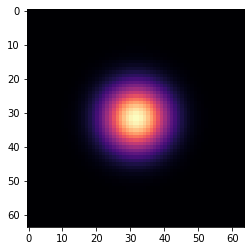

In [6]:
from scipy.stats import multivariate_normal

delta_pix = 2 * coordinate_limits / n_xy
sigma_psf = 0.05

x_kern = np.linspace(-6, 6, n_xy)
x, y = np.meshgrid(x_kern, x_kern)
source_image = multivariate_normal(mean=np.zeros(2), cov=np.ones(2) * sigma_psf / delta_pix).pdf(np.dstack((x, y)))
source_image /= np.sum(source_image)  # Normalize

plt.imshow(source_image, cmap='magma')

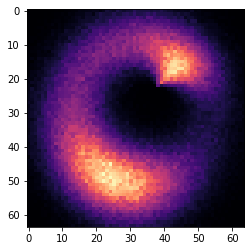

In [7]:
# Lens parameters
lens_dict = {"profile":"SIE", "theta_x_0":0.2, "theta_y_0":-0.3, "theta_E":0.7, "q":0.7}

# Observation configuration
observation_dict = {"theta_x_lims": [-coordinate_limits, coordinate_limits], "theta_y_lims": [-coordinate_limits, coordinate_limits], "n_x":n_xy, "n_y":n_xy, "exposure":1e8}

lensing_sim = LensingSim(lenses_list=[lens_dict], sources_list=[{"src_ary":source_image}], observation_dict=observation_dict)

# Create lensed image, including Poisson noise
lensed_image = np.random.poisson(lensing_sim.lensed_image())

plt.imshow(lensed_image, cmap='magma')

There's our Einstein ring!

## 3.&nbsp;Inferring the lens mass parameters

Now let's write down a model in NumPyro and performed parameter inference on the image we just simulated, like we did in the previous notebook.

In [8]:
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import SVI, Predictive, Trace_ELBO, autoguide
import numpyro.distributions as dist

from tqdm.notebook import tqdm

In [9]:
@jax.jit
def lensing_simulator(theta_x_0, theta_y_0, theta_E, q, src_ary):
    """ A convenience interface for the lensing forward simulator
    """

    n_xy = src_ary.shape[0]

    lens_dict = {"profile":"SIE", "theta_x_0":theta_x_0, "theta_y_0":theta_y_0, "theta_E":theta_E, "q":q}
    observation_dict = {"theta_x_lims": [-coordinate_limits, coordinate_limits], "theta_y_lims": [-coordinate_limits, coordinate_limits], "n_x":n_xy, "n_y":n_xy, "exposure":1e8}

    lensing_sim = LensingSim(lenses_list=[lens_dict], sources_list=[{"src_ary":src_ary}], observation_dict=observation_dict)

    lensed_image = lensing_sim.lensed_image()

    return lensed_image

In [10]:
def model(image):
    """ Model definition in NumPyro
    """

    # Stochastic nodes
    theta_x_0 = numpyro.sample("theta_x_0", dist.Uniform(0., 0.5))
    theta_y_0 = numpyro.sample("theta_y_0", dist.Normal(0., 0.5))
    theta_E = numpyro.sample("theta_E", dist.Uniform(0.1, 1.0))
    q = numpyro.sample("q", dist.Uniform(0.5, 0.99))

    # Deterministic node
    mu_pred = numpyro.deterministic("mu_pred", lensing_simulator(theta_x_0, theta_y_0, theta_E, q, source_image))

    # Use a plate to mark all pixels (i.e., data points along the two dimensions) as conditionally independent
    with numpyro.plate_stack('observed_data', image.shape, rightmost_dim=-1):
        return numpyro.sample("obs", dist.Poisson(mu_pred), obs=image)

In [11]:
# Define a guide (variational distribution)
guide = autoguide.AutoMultivariateNormal(model)

Perform variational inference using the high-level NumPyro interface.

In [12]:
optimizer = numpyro.optim.Adam(0.001)
svi = SVI(model, guide, optimizer, Trace_ELBO())
svi_results = svi.run(jax.random.PRNGKey(1), 10000, lensed_image)
params = svi_results.params

100%|██████████| 10000/10000 [00:19<00:00, 518.23it/s, init loss: 421281.0000, avg. loss [9501-10000]: 13558.5352]


Draw samples from the variational posterior and plot.

In [13]:
samples_svi = guide.sample_posterior(rng_key=jax.random.PRNGKey(0), params=params, sample_shape=(5000,))
samples_svi = np.array([samples_svi['theta_x_0'], samples_svi['theta_y_0'], samples_svi['theta_E'], samples_svi['q']]).T

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


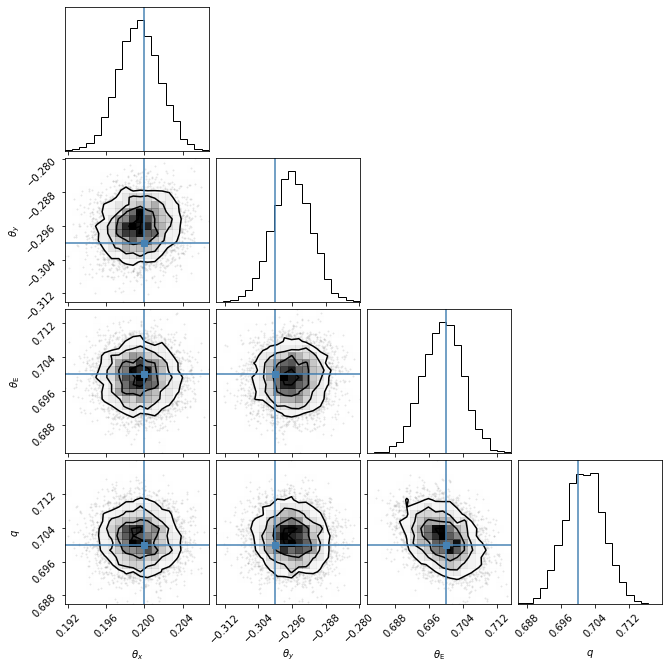

In [14]:
import corner

labels = [r"$\theta_x$", r"$\theta_y$", r"$\theta_\mathrm{E}$", r"$q$"]
corner.corner(samples_svi, truths=[0.2, -0.3, 0.7, 0.7], labels=labels);

Looks good hopefully!

## 4.&nbsp;Gravitational lensing of MNIST sources

Now the fun part. Let's see what happens when we gravitationally lens MNIST digits.

In [15]:
import tensorflow as tf
import tensorflow_datasets as tfds

Download and prepare dataset. Some boilerplate code to do so:

In [16]:
def prepare_image(x):
    """ Divide by max. quantized pixel value to reduce range to [0, 1]
    """
    x = tf.cast(x['image'], tf.float32) / 255.
    return x
    
tf.config.experimental.set_visible_devices([], 'GPU')

rng = random.PRNGKey(0)
rng, key = random.split(rng)

ds_builder = tfds.builder('mnist')
ds_builder.download_and_prepare()

train_ds = ds_builder.as_dataset(split=tfds.Split.TRAIN)
train_ds = train_ds.map(prepare_image)
train_ds = train_ds.cache()
train_ds = train_ds.repeat()
train_ds = train_ds.shuffle(50000)

test_ds = ds_builder.as_dataset(split=tfds.Split.TEST)
test_ds = test_ds.map(prepare_image).batch(10000)
test_ds = np.array(list(test_ds)[0])
test_ds = jax.device_put(test_ds)

Let's take an example image and gravitationally lens it, varying the Einstein radius (which controls the overall size of the lens).

In [17]:
@jax.jit
def lensing_simulator(theta_x_0, theta_y_0, theta_E, q, src_ary):
    """ A convenience interface for the lensing forward simulator
    """

    n_xy = src_ary.shape[0]

    lens_dict = {"profile":"SIE", "theta_x_0":theta_x_0, "theta_y_0":theta_y_0, "theta_E":theta_E, "q":q}
    observation_dict = {"theta_x_lims": [-coordinate_limits, coordinate_limits], "theta_y_lims": [-coordinate_limits, coordinate_limits], "n_x":n_xy, "n_y":n_xy, "exposure":1e4}

    lensing_sim = LensingSim(lenses_list=[lens_dict], sources_list=[{"src_ary":src_ary}], observation_dict=observation_dict)

    lensed_image = lensing_sim.lensed_image()

    return lensed_image

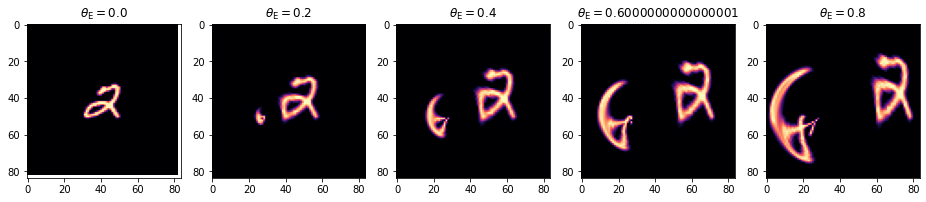

In [18]:
n_pad = 28  # Pad the MNIST images so they're more centered
idx_example = 0  # Test set example

src_mnist = np.pad(test_ds[idx_example, :, :, 0], (n_pad, n_pad))

n_img = 5
theta_E_ary = np.linspace(0., 0.8, n_img)

fig, ax = plt.subplots(1, n_img, figsize=(16,3))

for i_img in range(n_img):
  lensed_image = lensing_simulator(theta_x_0=0.2, theta_y_0=-0.3, theta_E=theta_E_ary[i_img], q=0.7, src_ary=src_mnist)
  ax[i_img].imshow(lensed_image.T, cmap='magma')
  ax[i_img].set_title(r"$\theta_\mathrm{{E}} = {}$".format(theta_E_ary[i_img]))

## 5.&nbsp;A generative model (VAE) for MNIST "sources"

We'll train a generative model (variational autoencoder) on MNIST, and use this in a probabilistic program to do inference.

We'll use the [Flax](https://flax.readthedocs.io/en/latest/index.html) neural network library.

<img src="https://lilianweng.github.io/posts/2018-08-12-vae/vae-gaussian.png#" alt="VAE" width="800"/>

Source: https://lilianweng.github.io/posts/2018-08-12-vae/

In [19]:
from flax import linen as nn
from flax.training import train_state

import optax
import tensorflow as tf
import tensorflow_datasets as tfds

/usr/local/lib/python3.7/dist-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


Set some hyperparameters:

In [20]:
# Hyperparameters
num_latents = 128  # Latent dimensionality of VAE bottleneck
num_epochs = 25
batch_size = 128
learning_rate = 1e-3

- Use either simple dense NNs (if using a CPU backend) or CNNs (if using an accelerator) for the encoder and decoder.
- Side note: the `ConvTranspose` in the CNN decoder is a transposed convolution, also known as a fractionally-strided convolution; see [here](https://github.com/vdumoulin/conv_arithmetic) for details, and [this paper](https://arxiv.org/abs/1603.07285) for more general explanations of convolution arithmetic. We can use it to increase the dimensionality of a 2-D representation.

Code adapted from https://github.com/google/flax/blob/main/examples/vae/.

In [22]:
arch = "dnn"  # ["dnn","cnn"] encoder/decoder

In [23]:
if arch == "cnn":  # Use simple CNN if using accelerator

  class Encoder(nn.Module):
      dim_hidden : int = 64
      dim_latents : int = 128

      @nn.compact
      def __call__(self, x):
          x = nn.Conv(features=self.dim_hidden, kernel_size=(3, 3), strides=2)(x) 
          x = nn.relu(x)
          x = nn.Conv(features=2 * self.dim_hidden, kernel_size=(3, 3), strides=2)(x)
          x = nn.relu(x)
          x = x.reshape(x.shape[0], -1)  # Flatten to single feature vector
          mean_x = nn.Dense(self.dim_latents)(x)
          logvar_x = nn.Dense(self.dim_latents)(x)
          return mean_x, logvar_x

  class Decoder(nn.Module):
      dim_hidden : int = 64

      @nn.compact
      def __call__(self, x):
          x = nn.Dense(features=7 * 7 *self.dim_hidden)(x)
          x = nn.relu(x)
          x = x.reshape(x.shape[0], 7, 7, -1)
          x = nn.ConvTranspose(features=2 * self.dim_hidden, kernel_size=(3, 3), strides=(2, 2))(x)
          x = nn.relu(x)
          x = nn.ConvTranspose(features=self.dim_hidden, kernel_size=(3, 3), strides=(2, 2))(x)
          x = nn.relu(x)
          x = nn.ConvTranspose(features=1, kernel_size=(3, 3), strides=(1, 1))(x)
          return x

elif arch == "dnn":  # Use simple dense NN

  class Encoder(nn.Module):
      dim_hidden : int = 256
      dim_latents : int = 128

      @nn.compact
      def __call__(self, x):
          x = x.reshape(x.shape[0], -1)
          for _ in range(2):
            x = nn.Dense(self.dim_hidden)(x)
            x = nn.relu(x)
          mean_x = nn.Dense(self.dim_latents)(x)
          logvar_x = nn.Dense(self.dim_latents)(x)
          return mean_x, logvar_x

  class Decoder(nn.Module):
      dim_hidden : int = 256

      @nn.compact
      def __call__(self, x):
          for _ in range(2):
            x = nn.Dense(self.dim_hidden)(x)
            x = nn.relu(x)
          x = nn.Dense(28 * 28)(x)
          x = x.reshape(x.shape[0], 28, 28, 1)
          return x

else:
  raise NotImplementedError

Now let's compose this for the VAE module.

In [56]:
class VAE(nn.Module):
    """ A simple variational auto-encoder module.
    """
    num_latents: int = 20

    def setup(self):
        self.encoder = Encoder(dim_latents=self.num_latents)
        self.decoder = Decoder()

    def __call__(self, x, z_rng):

        # Get variational parameters from encoder
        mu, logvar = self.encoder(x)

        # Sample from variational distrib. of latents
        z = numpyro.distributions.Normal(loc=mu, scale=jnp.sqrt(jnp.exp(logvar))).rsample(key=z_rng)

        # Decode
        recon_x = self.decoder(z)

        return recon_x, mu, logvar

    def generate(self, z):
        return nn.sigmoid(self.decoder(z))

@jax.vmap
def kl_divergence(mu, logvar):
    """ KL-divergence between latent variational distribution and unit Normal prior
    """
    prior_latent = numpyro.distributions.Normal(loc=0, scale=1)  # Prior
    q_latent = numpyro.distributions.Normal(loc=mu, scale=jnp.sqrt(jnp.exp(logvar)))  # Variational latent distrib.
    
    return numpyro.distributions.kl.kl_divergence(q_latent, prior_latent).sum()

@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
    logits = nn.log_sigmoid(logits)
    return -jnp.sum(labels * logits + (1. - labels) * jnp.log(-jnp.expm1(logits)))

def compute_metrics(recon_x, x, mu, logvar):
    bce_loss = binary_cross_entropy_with_logits(recon_x, x).mean()
    kld_loss = kl_divergence(mu, logvar).mean()
    return {
      'recon_loss': bce_loss,
      'kl_div': kld_loss,
      'loss': bce_loss + kld_loss
    }

def model_vae():
    return VAE(num_latents=num_latents)

In [57]:
@jax.jit
def train_step(state, batch, z_rng):
    def loss_fn(params):
        recon_x, mean, logvar = model_vae().apply({'params': params}, batch, z_rng)

        bce_loss = binary_cross_entropy_with_logits(recon_x, batch).mean()
        kld_loss = kl_divergence(mean, logvar).mean()
        loss = bce_loss + kld_loss
        return loss
    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads)

@jax.jit
def eval(params, images, z, z_rng):
    def eval_model(vae):
        recon_images, mean, logvar = vae(images, z_rng)
        comparison = jnp.concatenate([images[:8].reshape(-1, 28, 28, 1),
                                      recon_images[:8].reshape(-1, 28, 28, 1)])

        generate_images = vae.generate(z)
        generate_images = generate_images.reshape(-1, 28, 28, 1)
        metrics = compute_metrics(recon_images, images, mean, logvar)
        return metrics, comparison, generate_images

    return nn.apply(eval_model, model_vae())({'params': params})

In [65]:
train_ds = train_ds.batch(batch_size)
train_ds = iter(tfds.as_numpy(train_ds))

Initialize model state:

In [59]:
init_data = jnp.ones((batch_size, 28, 28, 1), jnp.float32)

state = train_state.TrainState.create(
    apply_fn=model_vae().apply,
    params=model_vae().init(key, init_data, rng)['params'],
    tx=optax.adam(learning_rate),
)

In [60]:
"The model has {} parameters".format(sum(x.size for x in jax.tree_util.tree_leaves(state.params)))

'The model has 632848 parameters'

In [61]:
rng, z_key, eval_rng = random.split(rng, 3)
z = random.normal(z_key, (64, num_latents))

steps_per_epoch = 50000 // batch_size

for epoch in range(num_epochs):
    for _ in range(steps_per_epoch):
        batch = next(train_ds)
        rng, key = random.split(rng)
        state = train_step(state, batch, key)

    metrics, comparison, sample = eval(state.params, test_ds, z, eval_rng)

    print('Epoch: {}, Loss: {:.4f}, Recon. loss: {:.4f}, KL-Div.: {:.4f}'.format(
      epoch + 1, metrics['loss'], metrics['recon_loss'], metrics['kl_div']
    ))

Epoch: 1, Loss: 155.2472, Recon. loss: 141.0053, KL-Div.: 14.2419
Epoch: 2, Loss: 137.8658, Recon. loss: 119.6809, KL-Div.: 18.1849
Epoch: 3, Loss: 126.2862, Recon. loss: 107.7557, KL-Div.: 18.5305
Epoch: 4, Loss: 118.7460, Recon. loss: 100.3710, KL-Div.: 18.3750
Epoch: 5, Loss: 114.3996, Recon. loss: 95.2926, KL-Div.: 19.1069
Epoch: 6, Loss: 112.0483, Recon. loss: 92.7459, KL-Div.: 19.3024
Epoch: 7, Loss: 110.1824, Recon. loss: 90.8176, KL-Div.: 19.3648
Epoch: 8, Loss: 109.0924, Recon. loss: 88.8488, KL-Div.: 20.2436
Epoch: 9, Loss: 107.8786, Recon. loss: 87.3107, KL-Div.: 20.5679
Epoch: 10, Loss: 107.3099, Recon. loss: 86.3611, KL-Div.: 20.9488
Epoch: 11, Loss: 106.8327, Recon. loss: 86.2315, KL-Div.: 20.6011
Epoch: 12, Loss: 105.9816, Recon. loss: 85.2422, KL-Div.: 20.7394
Epoch: 13, Loss: 105.9177, Recon. loss: 85.3346, KL-Div.: 20.5831
Epoch: 14, Loss: 105.4448, Recon. loss: 84.6705, KL-Div.: 20.7743
Epoch: 15, Loss: 104.7750, Recon. loss: 84.2829, KL-Div.: 20.4921
Epoch: 16, Loss

Draw random images by sampling and then decoding the latent space:

In [62]:
rng = jax.random.PRNGKey(12)
rng, z_key, eval_rng = random.split(rng, 3)
z = jax.random.normal(z_key, (16, num_latents))

In [63]:
metrics, comparison, sample = eval(state.params, test_ds, z, eval_rng)

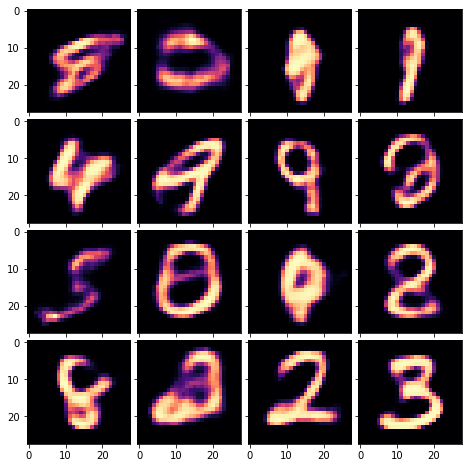

In [64]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(8., 8.))

grid = ImageGrid(fig, 111, nrows_ncols=(4, 4),axes_pad=0.1,)

for ax, im in zip(grid, sample[:, :, :, 0]):
    ax.imshow(im, cmap='magma')

## 6.&nbsp;Deep probabilistic programming model for lensing MNIST

Now we'll include the trained generative model inside the probabilistic progam as a model for the distribution of background sources. You can think of it as a "prior" on the background source distribution.

Start by generating the test image that we want to fit to.

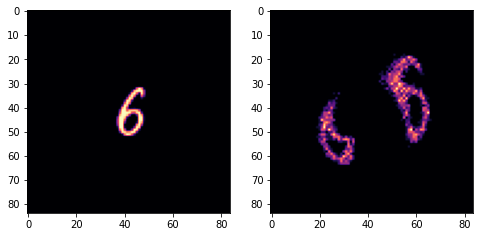

In [35]:
n_pad = 28  # Pad the MNIST images so they're more centered
idx_example = 7  # Test set example

src_mnist = np.pad(test_ds[idx_example, :, :, 0], (n_pad, n_pad))
lensed_image = lensing_simulator(theta_x_0=0.2, theta_y_0=-0.15, theta_E=0.5, q=0.7, src_ary=src_mnist)
lensed_image = np.random.poisson(lensed_image)

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].imshow(src_mnist, cmap='magma')
ax[1].imshow(lensed_image.T, cmap='magma')

Write a convenience function to generate decoded source images given a sampled set of latents.

In [36]:
def generate(vae, z):
  """ Decode image from VAE `vae` given a set of latents `z`
  """
  generate_images = vae.generate(z)
  generate_images = generate_images.reshape(-1, 28, 28, 1)
  return generate_images

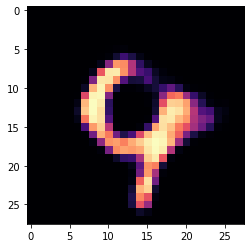

In [37]:
 # Draw some latent parameters from Gaussian prior
z_latent = jax.random.normal(z_key, (1, num_latents))

# Corresponding decoded image
img_decoded = nn.apply(generate, model_vae())({'params': state.params}, z_latent)
plt.imshow(img_decoded[0, :, :, 0], cmap='magma')

Define the probabilistic model.

In [45]:
def model(image):
    """ Model definition in NumPyro
    """
    
    # Stochastic nodes
    theta_x_0 = numpyro.sample("theta_x_0", dist.Uniform(0.01, 0.5))
    theta_y_0 = numpyro.sample("theta_y_0", dist.Normal(0., 0.5))
    theta_E = numpyro.sample("theta_E", dist.Uniform(0.1, 0.8))
    q = numpyro.sample("q", dist.Uniform(0.5, 0.99))

    z_latents = numpyro.sample("z_latents", dist.Normal(0., 1.), sample_shape=(1, num_latents))
    src_image = nn.apply(generate, model_vae())({'params': state.params}, z_latents)[0, :, :, 0] + 1e-15
    src_image = jnp.pad(src_image, (n_pad, n_pad))
        
    # Deterministic node
    mu_pred = numpyro.deterministic("mu_pred", lensing_simulator(theta_x_0, theta_y_0, theta_E, q, src_image))
    mu_pred = jnp.nan_to_num(mu_pred) + 1e-15

    # N different independent observations
    with numpyro.plate_stack('observed_data', image.shape, rightmost_dim=-1):
        return numpyro.sample("obs", dist.Poisson(mu_pred), obs=image)

In [46]:
# Define a guide (variational distribution)
guide = autoguide.AutoMultivariateNormal(model)

In [47]:
# Optimize lens variational parameters + source latents with VI
optimizer = numpyro.optim.Adam(0.001)
svi = SVI(model, guide, optimizer, Trace_ELBO())
svi_results = svi.run(jax.random.PRNGKey(1), 40000, lensed_image)
params = svi_results.params

100%|██████████| 40000/40000 [00:47<00:00, 833.71it/s, init loss: 15960.9219, avg. loss [38001-40000]: 1302.1436] 


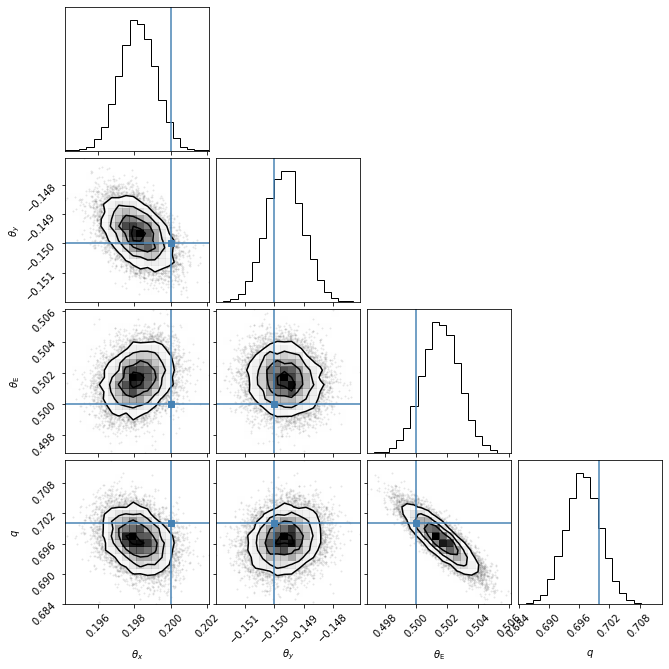

In [48]:
# Sample lens parameters
samples_svi = guide.sample_posterior(rng_key=jax.random.PRNGKey(0), params=params, sample_shape=(10000,))
samples_svi = np.array([samples_svi['theta_x_0'], samples_svi['theta_y_0'], samples_svi['theta_E'], samples_svi['q'] ]).T

labels = [r"$\theta_x$", r"$\theta_y$", r"$\theta_\mathrm{E}$", r"$q$"]
corner.corner(samples_svi, truths=[0.2, -0.15, 0.5, 0.7], labels=labels);

We now also have a posterior for the source, defined by the posterior over the parameters of the VAE latent space. Lets's draw some samples from this posterior to see if we've reconstructed the original source.

In [49]:
samples_svi = guide.sample_posterior(rng_key=jax.random.PRNGKey(0), params=params, sample_shape=(36,))
src_samples = nn.apply(generate, model_vae())({'params': state.params}, samples_svi['z_latents'])

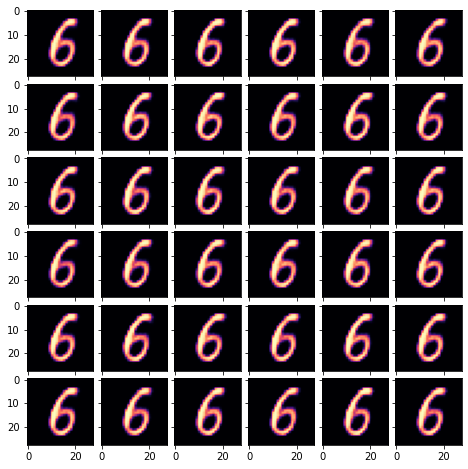

In [50]:
fig = plt.figure(figsize=(8., 8.))

grid = ImageGrid(fig, 111, nrows_ncols=(6, 6),axes_pad=0.1,)

for ax, im in zip(grid, src_samples[:, :, :, 0]):
    ax.imshow(im, cmap='magma')

Hopefully looks like a good description of the original source we had lensed! Let's animate the posterior for fun.

In [51]:
! pip install celluloid

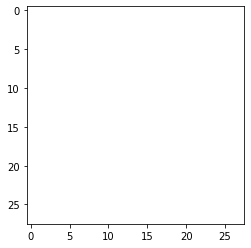

In [52]:
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure();
camera = Camera(fig);

for i in range(36):
    plt.imshow(src_samples[i, :, :, 0], cmap='magma');
    camera.snap()

animation = camera.animate();
HTML(animation.to_html5_video())

These are samples from the source posterior we have inferred.

In [42]:
# nuts_kernel = NUTS(model)

# mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=500)
# rng_key = jax.random.PRNGKey(1)
# mcmc.run(rng_key, lensed_image)